# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**
##### *Model Building Notebook*

## 1. Libraries

In [1]:
#! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl prettytable

# Tensorflow for CPU users
#! pip install tensorflow

In [19]:
import itertools
import random
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os, joblib
import openpyxl
import tensorflow as tf
import keras
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import windows, savgol_filter
from scipy.stats import boxcox

# Deep learning
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [20]:
# Reproducibility Setup
SEED = 42

# Python random seed
random.seed(SEED)

# NumPy seed
np.random.seed(SEED)

# TensorFlow seed
tf.random.set_seed(SEED)

# For reproducibility in TensorFlow (disable nondeterministic ops)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

## 2. Importing Final Datasts

In [21]:
# === Path to saved datasets ===
data_path = Path("final_datasets")

# === Read datasets (with Date as index) ===
final_df = pd.read_csv(data_path / "final_df.csv", index_col=0, parse_dates=True)
final_df_scaled = pd.read_csv(data_path / "final_df_scaled.csv", index_col=0, parse_dates=True)

print("Datasets loaded successfully:")
print("final_df shape:", final_df.shape)
print("final_df_scaled shape:", final_df_scaled.shape)

Datasets loaded successfully:
final_df shape: (256, 43)
final_df_scaled shape: (256, 43)


## 3. Feature Importance and Selection

### a. ADF Test

Sales (Rmn): Box-Cox λ = 0.8274
Volume: Box-Cox λ = 2.1332


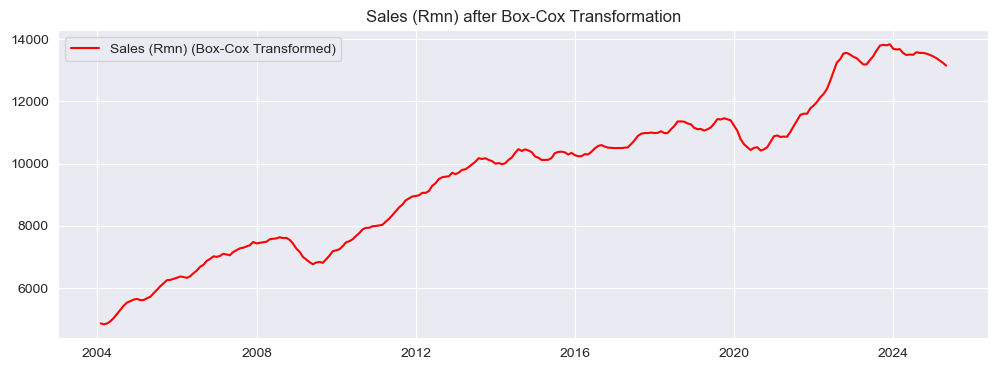

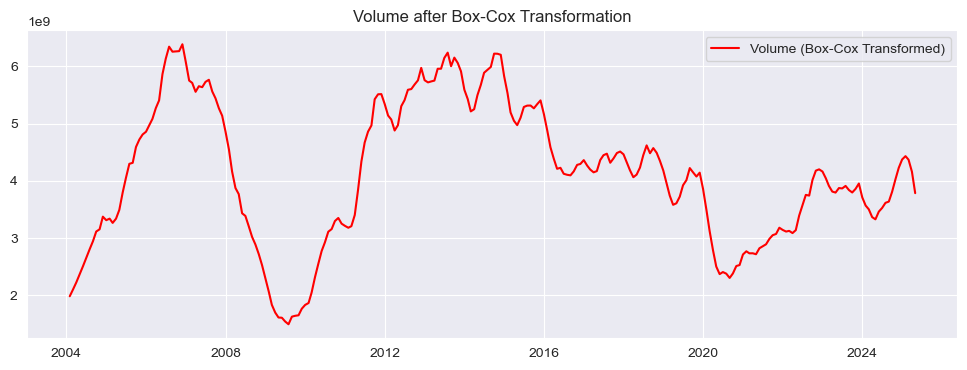

Augmented Dickey-Fuller Test: Sales (Rmn) after Box-Cox
ADF Statistic            -1.069265
p-value                   0.727172
# Lags Used              16.000000
# Observations          239.000000
Critical Value (1%)      -3.458011
Critical Value (5%)      -2.873710
Critical Value (10%)     -2.573256
Weak evidence against the null hypothesis → Non-stationary.

Augmented Dickey-Fuller Test: Volume after Box-Cox
ADF Statistic            -3.087808
p-value                   0.027469
# Lags Used              16.000000
# Observations          239.000000
Critical Value (1%)      -3.458011
Critical Value (5%)      -2.873710
Critical Value (10%)     -2.573256
Strong evidence against the null hypothesis → Stationary.



In [22]:
# --- Step 1: Box-Cox Transformation ---
def apply_boxcox_inplace(df, col_name):
    """
    Apply Box-Cox transform in place (replace column),
    ensuring positivity by shifting if necessary.
    Returns the lambda value for Box-Cox.
    """
    series = df[col_name].copy()

    # Ensure positive values
    if (series <= 0).any():
        shift = abs(series.min()) + 1
        series = series + shift
        print(f"{col_name}: Shifted by {shift} to make positive.")

    # Apply Box-Cox
    transformed, lam = boxcox(series)
    print(f"{col_name}: Box-Cox λ = {lam:.4f}")

    # If lambda ≈ 0, use log transform instead
    if np.isclose(lam, 0, atol=0.1):
        print(f"{col_name}: λ≈0 → using log-transform instead.")
        transformed = np.log(series)

    # Replace original column with transformed values
    df[col_name] = transformed
    return lam

# --- Step 2: ADF Test ---
def adf_test(series, title=''):
    """
    Run Augmented Dickey-Fuller test with clean output.
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis → Stationary.\n")
    else:
        print("Weak evidence against the null hypothesis → Non-stationary.\n")

# --- Apply transformations ---
lam_sales = apply_boxcox_inplace(final_df, 'Sales (Rmn)')
lam_volume = apply_boxcox_inplace(final_df, 'Volume')

# Plot transformed series
for col in ['Sales (Rmn)', 'Volume']:
    plt.figure(figsize=(12,4))
    plt.plot(final_df.index, final_df[col], label=f"{col} (Box-Cox Transformed)", color="red")
    plt.title(f"{col} after Box-Cox Transformation")
    plt.legend()
    plt.show()

# --- Step 3: COVID Dummy Variable ---
final_df['COVID_dummy'] = (final_df.index >= "2020-04-01").astype(int)

# --- Step 4: Run ADF Tests ---
adf_test(final_df['Sales (Rmn)'], 'Sales (Rmn) after Box-Cox')
adf_test(final_df['Volume'], 'Volume after Box-Cox')

##### Conclusion:

- we need to remove the trend and seasonality from 'Sales (Rmn)' variable since it is non-stationary

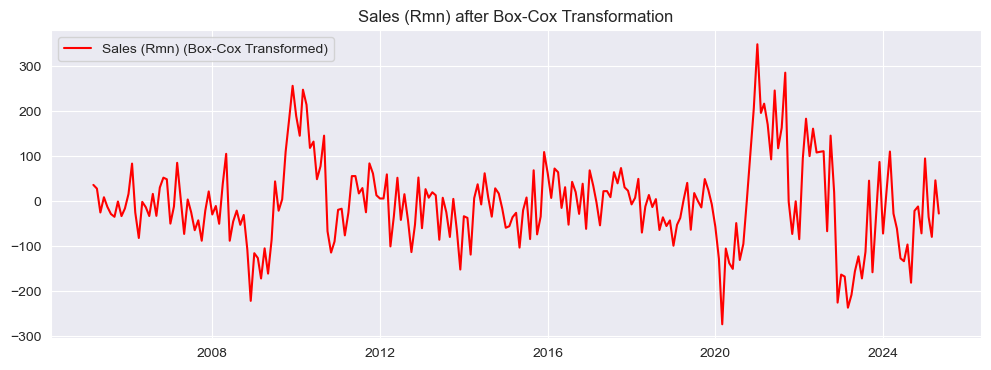

Augmented Dickey-Fuller Test: Sales (Rmn) - First Difference
ADF Statistic            -3.458895
p-value                   0.009108
# Lags Used              15.000000
# Observations          227.000000
Critical Value (1%)      -3.459490
Critical Value (5%)      -2.874358
Critical Value (10%)     -2.573602
Strong evidence against the null hypothesis → Stationary.



In [23]:
# First-order differencing
final_df['Sales (Rmn)'] = final_df['Sales (Rmn)'].diff().diff(12)
final_df_scaled['Sales (Rmn)'] = final_df_scaled['Sales (Rmn)'].diff().diff(12)

# Drop NA from differencing
final_df = final_df.dropna()
final_df_scaled = final_df_scaled.dropna()

# Re-run ADF test on differenced series
plt.figure(figsize=(12,4))
plt.plot(final_df.index, final_df['Sales (Rmn)'], label="Sales (Rmn) (Box-Cox Transformed)", color="red")
plt.title("Sales (Rmn) after Box-Cox Transformation")
plt.legend()
plt.show()

adf_test(final_df['Sales (Rmn)'], 'Sales (Rmn) - First Difference')

### b. Dataset Split

In [24]:
# For Scaled Data
X_scaled = final_df_scaled.drop(columns=['Sales (Rmn)', 'Volume'])
y1_scaled = final_df_scaled['Sales (Rmn)']
y2_scaled = final_df_scaled['Volume']

# TimeSeriesSplit (last fold will be used for train/test)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X_scaled):
    X_train_scaled, X_test_scaled = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y1_train_scaled, y1_test_scaled = y1_scaled.iloc[train_idx], y1_scaled.iloc[test_idx]
    y2_train_scaled, y2_test_scaled = y2_scaled.iloc[train_idx], y2_scaled.iloc[test_idx]


# For Raw Data
X = final_df.drop(columns=['Sales (Rmn)', 'Volume'])
y1 = final_df['Sales (Rmn)']
y2 = final_df['Volume']

# TimeSeriesSplit (last fold will be used for train/test)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y1_train, y1_test = y1.iloc[train_idx], y1.iloc[test_idx]
    y2_train, y2_test = y2.iloc[train_idx], y2.iloc[test_idx]

### c. Correlation Heatmap

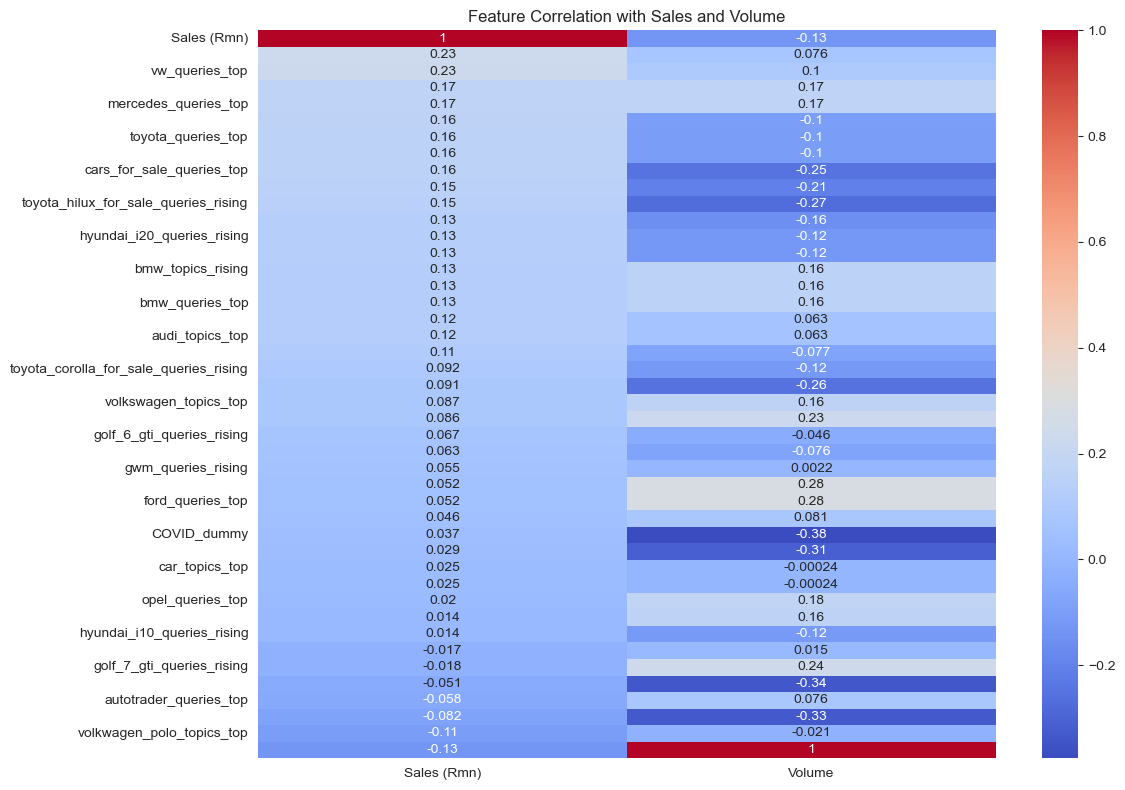

In [25]:
# Check correlations with Sales and Volume
correlation = final_df.corr(numeric_only=True)

# Heatmap of correlations with Sales and Volume
plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['Sales (Rmn)', 'Volume']].sort_values(by='Sales (Rmn)', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Sales and Volume")
plt.tight_layout()
plt.show()

### d. Feature Importance/Selection

In [26]:
# Feature filtering function
def filter_features_by_importance(X, y, threshold=0.001, n_estimators=200, n_repeats=30, random_state=42):
    # Fit RandomForest model
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)

    # Compute Permutation Importance
    pfi = permutation_importance(rf, X, y, n_repeats=n_repeats, random_state=random_state)

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': pfi.importances_mean
    }).sort_values(by='Importance', ascending=False)

    # Filter features based on threshold
    important_features = importance_df[importance_df['Importance'] > threshold]['Feature']
    X_filtered = X[important_features]

    # Reporting
    print(f"\nNumber of features before filtering: {X.shape[1]}")
    print(f"Number of features after filtering: {X_filtered.shape[1]}")
    print(f"Number of features dropped: {X.shape[1] - X_filtered.shape[1]}")
    print("="*50)
    print("Permutation Feature Importance Table:")
    X_filtered.info()

    return X_filtered

In [27]:
X1_train = filter_features_by_importance(X_train, y1_train, threshold=0.01)
X1_test = X_test[X1_train.columns]
X1_train_scaled = X_train_scaled[X1_train.columns]
X1_test_scaled = X_test_scaled[X1_train.columns]


Number of features before filtering: 42
Number of features after filtering: 25
Number of features dropped: 17
Permutation Feature Importance Table:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2005-02-28 to 2021-12-31
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   vw_queries_top                          203 non-null    int64
 1   toyota_hilux_for_sale_queries_rising    203 non-null    int64
 2   mercedes_benz_queries_top               203 non-null    int64
 3   nissan_queries_top                      203 non-null    int64
 4   autotrader_queries_top                  203 non-null    int64
 5   gwm_queries_rising                      203 non-null    int64
 6   hyundai_i10_queries_rising              203 non-null    int64
 7   volkswagen_topics_top                   203 non-null    int64
 8   kia_queries_top                         203 non-null

In [28]:
X2_train = filter_features_by_importance(X_train, y2_train, threshold=0.01)
X2_test = X_test[X2_train.columns]
X2_train_scaled = X_train_scaled[X2_train.columns]
X2_test_scaled = X_test_scaled[X2_train.columns]


Number of features before filtering: 42
Number of features after filtering: 12
Number of features dropped: 30
Permutation Feature Importance Table:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2005-02-28 to 2021-12-31
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   cars_queries_top            203 non-null    int64
 1   autotrader_queries_top      203 non-null    int64
 2   suzuki_queries_top          203 non-null    int64
 3   cars_for_sale_queries_top   203 non-null    int64
 4   opel_queries_top            203 non-null    int64
 5   ford_queries_top            203 non-null    int64
 6   ford_topics_top             203 non-null    int64
 7   hyundai_queries_top         203 non-null    int64
 8   gwm_queries_rising          203 non-null    int64
 9   honda_queries_top           203 non-null    int64
 10  golf_6_gti_queries_rising   203 non-null    int64
 11  hyundai

## 7. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA</td>
      <td>An extension of the non-seasonal ARIMA model, designed to handle data with seasonal patterns. It captures both short-term and long-term dependencies within the data</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>A variant of the regression version of the Support Vector Machines (SVM). It tries to fit a function that predicts future values while keeping prediction errors within a certain margin (ε-insensitive loss function).</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>A type of neural network that excels in this area. Unlike simple models, LSTMs can remember information for long periods, making them ideal for time series tasks where past data influences future values.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BI-LSTM</td>
      <td>An Extension of the LSTM model that integrates the input information from both past and future time steps. It's like predicting the middle words of a sentence by knowing both its first and last words.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines the CNNs power of learning local patterns in data, with the LSTMs ability to capture long-term dependencies in sequential data.</td>
      <td>Deep Learning</td>
    </tr>
  </tbody>
</table>

### a. Helper Functions

In [1]:
# Lag features
def create_lags(y, lags=12):
    df = pd.DataFrame({'y': y})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    return df.dropna()

# AIC/BIC approximation
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    resid = y_true - y_pred
    sigma2 = np.var(resid)
    loglik = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2*k - 2*loglik
    bic = np.log(n)*k - 2*loglik
    return aic, bic

# Standardized evaluation output
def evaluate_model(name, y_true, y_pred, k):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    aic, bic = calculate_aic_bic(y_true, y_pred, k)
    return [name, f"{aic:.2f}", f"{bic:.2f}", f"{rmse:.2f}", f"{mae:.2f}"]

def compute_residual_ci(y_true, y_pred, alpha=0.05):
    resid = y_true - y_pred
    std = np.std(resid)
    lower = y_pred - 1.96 * std
    upper = y_pred + 1.96 * std
    return lower, upper


# SARIMA
def train_sarima(y, order=(0,1,1), seasonal_order=(0,0,2,12), steps=12, trend="t"):
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast_obj = results.get_forecast(steps=steps)
    forecast = forecast_obj.predicted_mean
    ci = forecast_obj.conf_int()
    return results, forecast, ci

# SARIMAX
def train_sarimax(y, exog, exog_future, order=(0,1,1), seasonal_order=(0,0,2,12), steps=12, trend="t"):
    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast_obj = results.get_forecast(steps=steps, exog=exog_future)
    forecast = forecast_obj.predicted_mean
    ci = forecast_obj.conf_int()
    return results, forecast, ci

# SVR
def train_svr(X_train, y_train, X_test, kernel="rbf", C=1.0, gamma="scale"):
    # scikit-learn respects NumPy's global random seed
    model = SVR(kernel=kernel, C=C, gamma=gamma)
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    return model, forecast

def train_svr_multivariate(X_train, y_train, X_test, kernel="rbf", C=1.0, gamma="scale"):
    model = SVR(kernel=kernel, C=C, gamma=gamma)
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    return model, forecast


# Build Neural Networks
def build_model(model_type, input_shape, units=64, filters=64, kernel_size=3, pool_size=2, lr=0.001, dropout=0.2):
    model = Sequential()

    if model_type == "lstm":
        model.add(LSTM(units, activation="tanh", return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(LSTM(units//2, activation="tanh"))

    elif model_type == "bilstm":
        model.add(Bidirectional(LSTM(units, activation="tanh", return_sequences=True), input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(Bidirectional(LSTM(units//2, activation="tanh")))

    elif model_type == "cnnlstm":
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape))
        model.add(Conv1D(filters=filters//2, kernel_size=2, activation="relu"))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))
        model.add(LSTM(units, activation="tanh", return_sequences=True))
        model.add(LSTM(units//2, activation="tanh"))

    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model


# === Training function stays mostly the same ===
def train_nn_univariate(y_train, y_test, model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    # Create lagged features
    train_df = create_lags(y_train, lags)
    X_train = train_df.drop("y", axis=1).values
    y_train_lag = train_df["y"].values

    # Reshape to [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build and fit model
    model = build_model(model_type, (X_train.shape[1], X_train.shape[2]), **kwargs)
    model.fit(X_train, y_train_lag, epochs=epochs, batch_size=batch_size, verbose=0)

    # Recursive forecast
    forecast = []
    last_window = y_train[-lags:].tolist()
    for _ in range(len(y_test)):
        X_pred = np.array(last_window[-lags:]).reshape((1, lags, 1))
        y_pred = model.predict(X_pred, verbose=0)[0, 0]
        forecast.append(y_pred)
        last_window.append(y_pred)

    return model, np.array(forecast)

def train_nn_multivariate(X_train, y_train, X_test, model_type="lstm", epochs=20, batch_size=16, **kwargs):
    # Ensure X_train is 3D: [samples, timesteps, features]
    if X_train.ndim != 3:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))

    model = build_model(model_type, (X_train.shape[1], X_train.shape[2]), **kwargs)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Forecast directly on test set
    forecast = model.predict(X_test, verbose=0).flatten()
    return model, forecast


### b. Sales

#### i. Model Building

In [ ]:
results = []

# === SARIMA (Univariate) ===
sarima_res, sarima_forecast, sarima_ci = train_sarima(y1_train_scaled, steps=len(y1_test_scaled))
results.append(evaluate_model("SARIMA", y1_test_scaled, sarima_forecast, k=3))

# === SARIMAX (Multivariate) ===
sarimax_res, sarimax_forecast, sarimax_ci = train_sarimax(y1_train_scaled, X1_train_scaled, X1_test_scaled, steps=len(y1_test_scaled))
results.append(evaluate_model("SARIMAX", y1_test_scaled, sarimax_forecast, k=3 + X1_train_scaled.shape[1]))

# === LSSVR (Univariate) ===
lssvr_model, lssvr_forecast = train_svr(X1_train_scaled[:, :1], y1_train_scaled, X1_test_scaled[:, :1])
lssvr_lower, lssvr_upper = compute_residual_ci(y1_test_scaled, lssvr_forecast)
results.append(evaluate_model("LSSVR-Uni", y1_test_scaled, lssvr_forecast, k=1))

# === LSSVR (Multivariate) ===
lssvr_mv_model, lssvr_mv_forecast = train_svr_multivariate(X1_train_scaled, y1_train_scaled, X1_test_scaled)
lssvr_mv_lower, lssvr_mv_upper = compute_residual_ci(y1_test_scaled, lssvr_mv_forecast)
results.append(evaluate_model("LSSVR-Multi", y1_test_scaled, lssvr_mv_forecast, k=X1_train_scaled.shape[1]))

# === LSTM (Univariate) ===
lstm_model, lstm_forecast = train_nn_univariate(y1_train_scaled.values, y1_test_scaled.values, model_type="lstm")
lstm_lower, lstm_upper = compute_residual_ci(y1_test_scaled, lstm_forecast)
results.append(evaluate_model("LSTM-Uni", y1_test_scaled, lstm_forecast, k=12+50))

# === LSTM (Multivariate) ===
# Reshape X_train/X_test: [samples, timesteps, features] for NN
X_train_nn = X1_train_scaled.reshape((X1_train_scaled.shape[0], 1, X1_train_scaled.shape[1]))
X_test_nn = X1_test_scaled.reshape((X1_test_scaled.shape[0], 1, X1_test_scaled.shape[1]))
lstm_mv_model, lstm_mv_forecast = train_nn_multivariate(X_train_nn, y1_train_scaled, X_test_nn, model_type="lstm")
lstm_mv_lower, lstm_mv_upper = compute_residual_ci(y1_test_scaled, lstm_mv_forecast)
results.append(evaluate_model("LSTM-Multi", y1_test_scaled, lstm_mv_forecast, k=X1_train_scaled.shape[1]))

# === BiLSTM (Univariate) ===
bilstm_model, bilstm_forecast = train_nn_univariate(y1_train_scaled.values, y1_test_scaled.values, model_type="bilstm")
bilstm_lower, bilstm_upper = compute_residual_ci(y1_test_scaled, bilstm_forecast)
results.append(evaluate_model("BiLSTM-Uni", y1_test_scaled, bilstm_forecast, k=12+50))

# === BiLSTM (Multivariate) ===
bilstm_mv_model, bilstm_mv_forecast = train_nn_multivariate(X_train_nn, y1_train_scaled, X_test_nn, model_type="bilstm")
bilstm_mv_lower, bilstm_mv_upper = compute_residual_ci(y1_test_scaled, bilstm_mv_forecast)
results.append(evaluate_model("BiLSTM-Multi", y1_test_scaled, bilstm_mv_forecast, k=X1_train_scaled.shape[1]))

# === CNN-LSTM (Univariate) ===
cnnlstm_model, cnnlstm_forecast = train_nn_univariate(y1_train_scaled.values, y1_test_scaled.values, model_type="cnnlstm")
cnnlstm_lower, cnnlstm_upper = compute_residual_ci(y1_test_scaled, cnnlstm_forecast)
results.append(evaluate_model("CNN-LSTM-Uni", y1_test_scaled, cnnlstm_forecast, k=12+50+64))

# === CNN-LSTM (Multivariate) ===
cnnlstm_mv_model, cnnlstm_mv_forecast = train_nn_multivariate(X_train_nn, y1_train_scaled, X_test_nn, model_type="cnnlstm")
cnnlstm_mv_lower, cnnlstm_mv_upper = compute_residual_ci(y1_test_scaled, cnnlstm_mv_forecast)
results.append(evaluate_model("CNN-LSTM-Multi", y1_test_scaled, cnnlstm_mv_forecast, k=X1_train_scaled.shape[1]))

# --- Performance Comparison Table ---
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "AIC", "BIC", "RMSE", "MAE"]

for res in results:
    table.add_row(res)

print("\n=== Model Performance Comparison: Univariate vs Multivariate ===")
print(table)


#### ii. Plots

In [59]:
fig = go.Figure()

# === Actual data ===
fig.add_trace(go.Scatter(
    x=y1_scaled.index, y=y1_scaled, mode='lines',
    name='Actual', line=dict(width=2),
    legendgroup="Actual"
))

# Last training point
last_train_x = y1_train_scaled.index[-1]
last_train_y = y1_train_scaled.values[-1]

# === SARIMA ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(sarima_forecast),
    mode='lines', name='SARIMA', legendgroup="SARIMA"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(sarima_ci.iloc[:,0]),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="SARIMA"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(sarima_ci.iloc[:,1]),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(0,100,250,0.2)',
    showlegend=False, legendgroup="SARIMA"
))

# === SARIMAX ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(sarimax_forecast),
    mode='lines', name='SARIMAX', legendgroup="SARIMAX"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(sarimax_ci.iloc[:,0]),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="SARIMAX"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(sarimax_ci.iloc[:,1]),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(100,250,100,0.2)',
    showlegend=False, legendgroup="SARIMAX"
))

# === LSSVR ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(lssvr_forecast),
    mode='lines', name='LSSVR', legendgroup="LSSVR"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(lssvr_lower),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="LSSVR"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(lssvr_upper),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(250,100,0,0.2)',
    showlegend=False, legendgroup="LSSVR"
))

# === LSTM ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(lstm_forecast),
    mode='lines', name='LSTM', legendgroup="LSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(lstm_lower),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="LSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(lstm_upper),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(250,0,250,0.2)',
    showlegend=False, legendgroup="LSTM"
))

# === BiLSTM ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(bilstm_forecast),
    mode='lines', name='BiLSTM', legendgroup="BiLSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(bilstm_lower),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="BiLSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(bilstm_upper),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(150,0,250,0.2)',
    showlegend=False, legendgroup="BiLSTM"
))

# === CNN-LSTM ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(cnnlstm_forecast),
    mode='lines', name='CNN-LSTM', legendgroup="CNN-LSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(cnnlstm_lower),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="CNN-LSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y1_test_scaled.index),
    y=[last_train_y] + list(cnnlstm_upper),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(0,200,200,0.2)',
    showlegend=False, legendgroup="CNN-LSTM"
))

# === Layout ===
fig.update_layout(
    title='Sales Forecast Comparison',
    xaxis_title='Date',
    yaxis_title='Scaled Values',
    template='plotly_white',
    legend=dict(title='Models')
)

fig.show()


### c. Volume

#### i. Model Building

In [ ]:
results = []

# === SARIMA (Univariate) ===
sarima_res, sarima_forecast, sarima_ci = train_sarima(y2_train_scaled, steps=len(y2_test_scaled))
results.append(evaluate_model("SARIMA", y2_test_scaled, sarima_forecast, k=3))

# === SARIMAX (Multivariate) ===
sarimax_res, sarimax_forecast, sarimax_ci = train_sarimax(y2_train_scaled, X2_train_scaled, X2_test_scaled, steps=len(y2_test_scaled))
results.append(evaluate_model("SARIMAX", y2_test_scaled, sarimax_forecast, k=3 + X2_train_scaled.shape[1]))

# === LSSVR (Univariate) ===
lssvr_model, lssvr_forecast = train_svr(X2_train_scaled[:, :1], y2_train_scaled, X2_test_scaled[:, :1])
lssvr_lower, lssvr_upper = compute_residual_ci(y2_test_scaled, lssvr_forecast)
results.append(evaluate_model("LSSVR-Uni", y2_test_scaled, lssvr_forecast, k=1))

# === LSSVR (Multivariate) ===
lssvr_mv_model, lssvr_mv_forecast = train_svr_multivariate(X2_train_scaled, y2_train_scaled, X2_test_scaled)
lssvr_mv_lower, lssvr_mv_upper = compute_residual_ci(y2_test_scaled, lssvr_mv_forecast)
results.append(evaluate_model("LSSVR-Multi", y2_test_scaled, lssvr_mv_forecast, k=X2_train_scaled.shape[1]))

# === LSTM (Univariate) ===
lstm_model, lstm_forecast = train_nn_univariate(y2_train_scaled.values, y2_test_scaled.values, model_type="lstm")
lstm_lower, lstm_upper = compute_residual_ci(y2_test_scaled, lstm_forecast)
results.append(evaluate_model("LSTM-Uni", y2_test_scaled, lstm_forecast, k=12+50))

# === LSTM (Multivariate) ===
# Reshape X_train/X_test: [samples, timesteps, features] for NN
X_train_nn = X2_train_scaled.reshape((X2_train_scaled.shape[0], 1, X2_train_scaled.shape[1]))
X_test_nn = X2_test_scaled.reshape((X2_test_scaled.shape[0], 1, X2_test_scaled.shape[1]))
lstm_mv_model, lstm_mv_forecast = train_nn_multivariate(X_train_nn, y2_train_scaled, X_test_nn, model_type="lstm")
lstm_mv_lower, lstm_mv_upper = compute_residual_ci(y2_test_scaled, lstm_mv_forecast)
results.append(evaluate_model("LSTM-Multi", y2_test_scaled, lstm_mv_forecast, k=X2_train_scaled.shape[1]))

# === BiLSTM (Univariate) ===
bilstm_model, bilstm_forecast = train_nn_univariate(y2_train_scaled.values, y2_test_scaled.values, model_type="bilstm")
bilstm_lower, bilstm_upper = compute_residual_ci(y2_test_scaled, bilstm_forecast)
results.append(evaluate_model("BiLSTM-Uni", y2_test_scaled, bilstm_forecast, k=12+50))

# === BiLSTM (Multivariate) ===
bilstm_mv_model, bilstm_mv_forecast = train_nn_multivariate(X_train_nn, y2_train_scaled, X_test_nn, model_type="bilstm")
bilstm_mv_lower, bilstm_mv_upper = compute_residual_ci(y2_test_scaled, bilstm_mv_forecast)
results.append(evaluate_model("BiLSTM-Multi", y2_test_scaled, bilstm_mv_forecast, k=X2_train_scaled.shape[1]))

# === CNN-LSTM (Univariate) ===
cnnlstm_model, cnnlstm_forecast = train_nn_univariate(y2_train_scaled.values, y2_test_scaled.values, model_type="cnnlstm")
cnnlstm_lower, cnnlstm_upper = compute_residual_ci(y2_test_scaled, cnnlstm_forecast)
results.append(evaluate_model("CNN-LSTM-Uni", y2_test_scaled, cnnlstm_forecast, k=12+50+64))

# === CNN-LSTM (Multivariate) ===
cnnlstm_mv_model, cnnlstm_mv_forecast = train_nn_multivariate(X_train_nn, y2_train_scaled, X_test_nn, model_type="cnnlstm")
cnnlstm_mv_lower, cnnlstm_mv_upper = compute_residual_ci(y2_test_scaled, cnnlstm_mv_forecast)
results.append(evaluate_model("CNN-LSTM-Multi", y2_test_scaled, cnnlstm_mv_forecast, k=X2_train_scaled.shape[1]))

# --- Performance Comparison Table ---
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "AIC", "BIC", "RMSE", "MAE"]

for res in results:
    table.add_row(res)

print("\n=== Model Performance Comparison: Univariate vs Multivariate ===")
print(table)


#### ii. Plots

In [55]:
fig = go.Figure()

# === Actual data ===
fig.add_trace(go.Scatter(
    x=y2_scaled.index, y=y2_scaled, mode='lines',
    name='Actual', line=dict(width=2),
    legendgroup="Actual"
))

# Last training point
last_train_x = y2_train_scaled.index[-1]
last_train_y = y2_train_scaled.values[-1]

# === SARIMA ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(sarima_forecast),
    mode='lines', name='SARIMA', legendgroup="SARIMA"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(sarima_ci.iloc[:,0]),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="SARIMA"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(sarima_ci.iloc[:,1]),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(0,100,250,0.2)',
    showlegend=False, legendgroup="SARIMA"
))

# === SARIMAX ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(sarimax_forecast),
    mode='lines', name='SARIMAX', legendgroup="SARIMAX"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(sarimax_ci.iloc[:,0]),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="SARIMAX"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(sarimax_ci.iloc[:,1]),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(100,250,100,0.2)',
    showlegend=False, legendgroup="SARIMAX"
))

# === LSSVR ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(lssvr_forecast),
    mode='lines', name='LSSVR', legendgroup="LSSVR"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(lssvr_lower),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="LSSVR"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(lssvr_upper),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(250,100,0,0.2)',
    showlegend=False, legendgroup="LSSVR"
))

# === LSTM ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(lstm_forecast),
    mode='lines', name='LSTM', legendgroup="LSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(lstm_lower),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="LSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(lstm_upper),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(250,0,250,0.2)',
    showlegend=False, legendgroup="LSTM"
))

# === BiLSTM ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(bilstm_forecast),
    mode='lines', name='BiLSTM', legendgroup="BiLSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(bilstm_lower),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="BiLSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(bilstm_upper),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(150,0,250,0.2)',
    showlegend=False, legendgroup="BiLSTM"
))

# === CNN-LSTM ===
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(cnnlstm_forecast),
    mode='lines', name='CNN-LSTM', legendgroup="CNN-LSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(cnnlstm_lower),
    mode='lines', line=dict(width=0),
    showlegend=False, legendgroup="CNN-LSTM"
))
fig.add_trace(go.Scatter(
    x=[last_train_x] + list(y2_test_scaled.index),
    y=[last_train_y] + list(cnnlstm_upper),
    mode='lines', line=dict(width=0),
    fill='tonexty', fillcolor='rgba(0,200,200,0.2)',
    showlegend=False, legendgroup="CNN-LSTM"
))

# === Layout ===
fig.update_layout(
    title='Volume Forecast Comparison (Anchored)',
    xaxis_title='Date',
    yaxis_title='Scaled Values',
    template='plotly_white',
    legend=dict(title='Models')
)

fig.show()
